In [22]:
# pip install fair-esm torch umap-learn scikit-learn biopython matplotlib

import requests, gzip, io
from Bio import SeqIO, AlignIO
import pandas as pd
from collections import Counter
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.manifold import trustworthiness
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import umap
import matplotlib.pyplot as plt

In [23]:
import torch, esm
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [24]:
# -----------------------------
# Step 1: Download Pfam-A.seed.gz
# -----------------------------
url = "https://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.seed.gz"
response = requests.get(url, stream=True)
response.raise_for_status()

pfam_ids = ["PF00069", "PF00072"]  # Protein kinase + GPCR example
records_by_family = {pfam: [] for pfam in pfam_ids}



In [25]:
# -----------------------------
# Step 2: Parse manually, track #=GF AC
# -----------------------------
current_acc = None
block_lines = []

def process_block(block_lines, current_acc):
    """Convert collected lines into an alignment and store if matches PFAM IDs"""
    if not block_lines or current_acc not in records_by_family:
        return
    block_text = "# STOCKHOLM 1.0\n" + "".join(block_lines) + "//\n"
    handle = io.StringIO(block_text)
    alignment = AlignIO.read(handle, "stockholm")
    records_by_family[current_acc].extend(alignment)

with gzip.open(io.BytesIO(response.content), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            process_block(block_lines, current_acc)
            block_lines = [line]
            current_acc = line.split()[2].split(".")[0]  # strip version
        elif line.strip() == "//":
            block_lines.append(line)
            process_block(block_lines, current_acc)
            block_lines = []
            current_acc = None
        else:
            block_lines.append(line)

for pfam, seqs in records_by_family.items():
    print(f"{pfam}: {len(seqs)} sequences")




PF00069: 38 sequences
PF00072: 52 sequences


          A         C         D         E         F         G         H  \
0  0.021480  0.009547  0.045346  0.033413  0.011933  0.026253  0.019093   
1  0.031026  0.009547  0.023866  0.050119  0.031026  0.047733  0.007160   
2  0.014320  0.009547  0.033413  0.033413  0.016706  0.045346  0.021480   
3  0.021480  0.016706  0.031026  0.031026  0.021480  0.050119  0.019093   
4  0.052506  0.009547  0.033413  0.038186  0.021480  0.045346  0.014320   

          I         K         L  ...         N         P         Q         R  \
0  0.066826  0.064439  0.052506  ...  0.033413  0.031026  0.038186  0.014320   
1  0.054893  0.045346  0.059666  ...  0.033413  0.028640  0.021480  0.028640   
2  0.076372  0.052506  0.062053  ...  0.045346  0.023866  0.021480  0.028640   
3  0.052506  0.028640  0.071599  ...  0.023866  0.031026  0.019093  0.031026   
4  0.052506  0.033413  0.066826  ...  0.028640  0.038186  0.011933  0.033413   

          S         T         V         W         Y   family  
0  0.

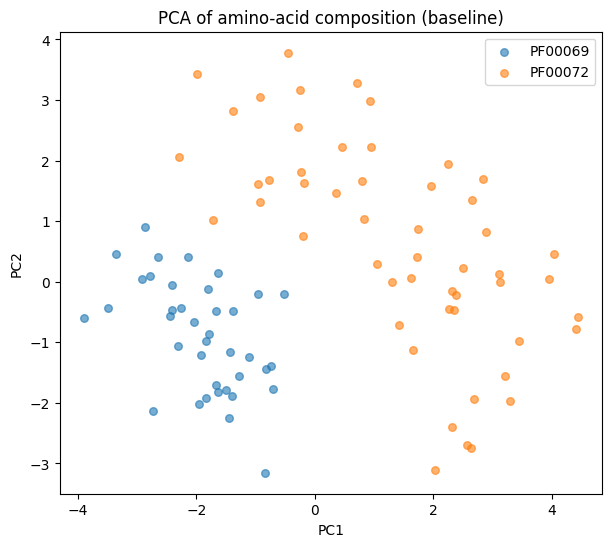

In [26]:
# -----------------------------
# Step 3: Simple amino-acid composition PCA (baseline EDA)
# -----------------------------
aa_list = list("ACDEFGHIKLMNPQRSTVWY")

def seq_to_composition(seq):
    counts = Counter(str(seq))
    return [counts.get(aa, 0) / len(seq) for aa in aa_list]

all_data, all_labels = [], []
for pfam, seqs in records_by_family.items():
    for record in seqs:
        comp = seq_to_composition(record.seq)
        all_data.append(comp)
        all_labels.append(pfam)

df = pd.DataFrame(all_data, columns=aa_list)
df["family"] = all_labels
print(df.head())

if not df.empty:
    X = StandardScaler().fit_transform(df[aa_list])
    pca = PCA(n_components=2, random_state=0)
    pcs = pca.fit_transform(X)

    plt.figure(figsize=(7,6))
    for fam in pfam_ids:
        mask = (df["family"] == fam).values
        plt.scatter(pcs[mask,0], pcs[mask,1], label=fam, alpha=0.6, s=30)
    plt.title("PCA of amino-acid composition (baseline)")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.show()
else:
    print("No sequences found for the selected Pfam IDs.")



In [27]:
# =====================================================================
# === Lite ESM-2 embedding pipeline (macOS / MPS) =====================
# =====================================================================

# device: MPS on Apple Silicon, else CPU
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# --- Choose a lighter checkpoint (swap one line to change size) ---
# Options: esm2_t6_8M_UR50D (tiny), esm2_t12_35M_UR50D (small), esm2_t30_150M_UR50D (medium)
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model = model.eval().to(device)
batch_converter = alphabet.get_batch_converter()

# --- Sequence prep: keep only standard tokens + length cap / chunk ---
MAX_LEN = 512   # for MPS, 512 is a good default
CHUNK_LEN = None  # set to 512 to chunk-and-average instead of cropping

def clean_seq(seq, alphabet):
    toks = set(alphabet.standard_toks)
    return "".join([c for c in str(seq) if c in toks])

def crop_center(seq, max_len):
    if len(seq) <= max_len:
        return seq
    start = (len(seq) - max_len)//2
    return seq[start:start+max_len]

def chunk_and_average(seq, chunk_len):
    return [seq[i:i+chunk_len] for i in range(0, len(seq), chunk_len)
            if len(seq[i:i+chunk_len]) >= 50]

seqs_lite, y_lite = [], []
for pfam, recs in records_by_family.items():
    for rec in recs:
        s = clean_seq(rec.seq, alphabet)
        if not s:
            continue
        if CHUNK_LEN:
            windows = chunk_and_average(s, CHUNK_LEN)
            if not windows: 
                continue
            for wi, w in enumerate(windows):
                seqs_lite.append((f"{rec.id}_w{wi}", w))
                y_lite.append(pfam)
        else:
            s = crop_center(s, MAX_LEN)
            if 50 <= len(s) <= MAX_LEN:
                seqs_lite.append((rec.id, s))
                y_lite.append(pfam)

print(f"Prepared {len(seqs_lite)} sequences for ESM-lite on device={device}")



Prepared 90 sequences for ESM-lite on device=mps


In [28]:
# --- Embedding with (optional) mixed precision on MPS ---
# Note: bfloat16 isn't supported on MPS; use float16 autocast.
embeds = []
batch_size = 16 if (device == "mps") else 4  # tweak up/down if you hit memory issues

def embed_batch(batch):
    labels, strs, toks = batch_converter(batch)
    toks = toks.to(device)

    def _forward():
        return model(toks, repr_layers=[model.num_layers], return_contacts=False)

    with torch.no_grad():
        if device == "mps":
            # try fp16 autocast on MPS; fall back to fp32 if an op isn't supported
            try:
                with torch.autocast(device_type="mps", dtype=torch.float16):
                    out = _forward()
            except RuntimeError:
                out = _forward()
        else:
            # CPU path
            out = _forward()

    reps = out["representations"][model.num_layers].detach().cpu().numpy()
    vecs = []
    for j, s in enumerate(strs):
        L = len(s)
        vecs.append(reps[j, 1:1+L, :].mean(axis=0))
    return vecs

for i in range(0, len(seqs_lite), batch_size):
    batch = seqs_lite[i:i+batch_size]
    embeds.extend(embed_batch(batch))

X_esm = np.vstack(embeds).astype(np.float32)

# If you used chunking (CHUNK_LEN), average vectors back per original id:
if CHUNK_LEN:
    id_roots = [sid.rsplit("_w", 1)[0] if "_w" in sid else sid for sid, _ in seqs_lite]
    df_emb = pd.DataFrame(X_esm)
    df_emb["root"] = id_roots
    df_emb["family"] = y_lite
    X_esm = df_emb.groupby("root").mean().values
    y_series = df_emb.groupby("root")["family"].agg(lambda s: s.mode().iat[0])
    y_lite = y_series.values



In [29]:
# --- Normalize -> PCA(valid) -> UMAP(2) ---
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import umap
import numpy as np

# L2-normalize rows (good with cosine distances later)
X_esm = normalize(X_esm)

# Choose a valid PCA dimensionality:
n_samples, n_features = X_esm.shape
max_valid = min(100, n_samples, n_features)          # must be ≤ min(n_samples, n_features)
n_components = max(2, max_valid)                     # keep at least 2 for UMAP input

X_pca = PCA(n_components=n_components, random_state=0).fit_transform(X_esm)

um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=0,
)
X_umap = um.fit_transform(X_pca)


/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Trustworthiness — UMAP (ESM-lite): 0.955
5-NN CV accuracy — UMAP (ESM-lite): 1.000 ± 0.000


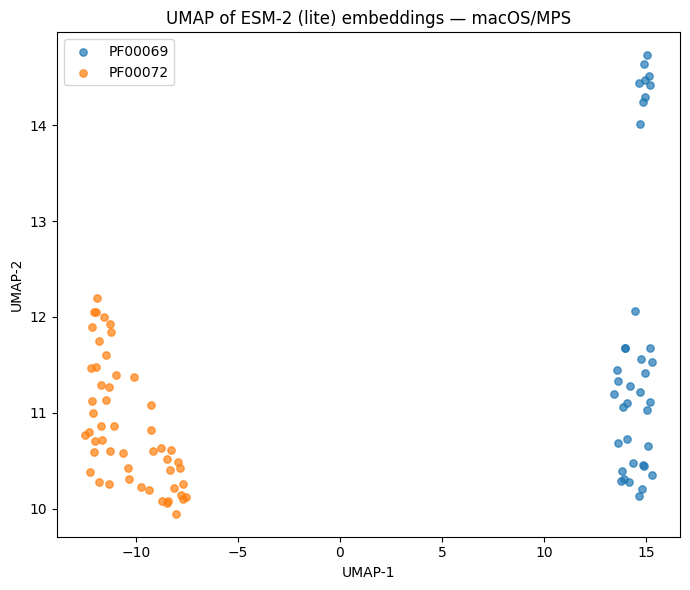

In [21]:
# --- Metrics: trustworthiness & 5-NN CV accuracy (cosine) ---
from sklearn.manifold import trustworthiness
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

tw = trustworthiness(X_pca, X_umap, n_neighbors=10, metric="euclidean")
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs = cross_val_score(knn, X_umap, y_lite, cv=cv)
acc_mean, acc_sd = accs.mean(), accs.std()

print(f"Trustworthiness — UMAP (ESM-lite): {tw:.3f}")
print(f"5-NN CV accuracy — UMAP (ESM-lite): {acc_mean:.3f} ± {acc_sd:.3f}")

# --- Plot UMAP ---
plt.figure(figsize=(7,6))
labels_arr = np.array(y_lite)
for fam in pfam_ids:
    mask = (labels_arr == fam)
    plt.scatter(X_umap[mask,0], X_umap[mask,1], label=fam, alpha=0.7, s=28)
plt.title("UMAP of ESM-2 (lite) embeddings — macOS/MPS")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.legend()
plt.tight_layout(); plt.show()

Trustworthiness — UMAP (ESM-lite): 0.953
5-NN CV accuracy — UMAP (ESM-lite): 0.944 ± 0.035


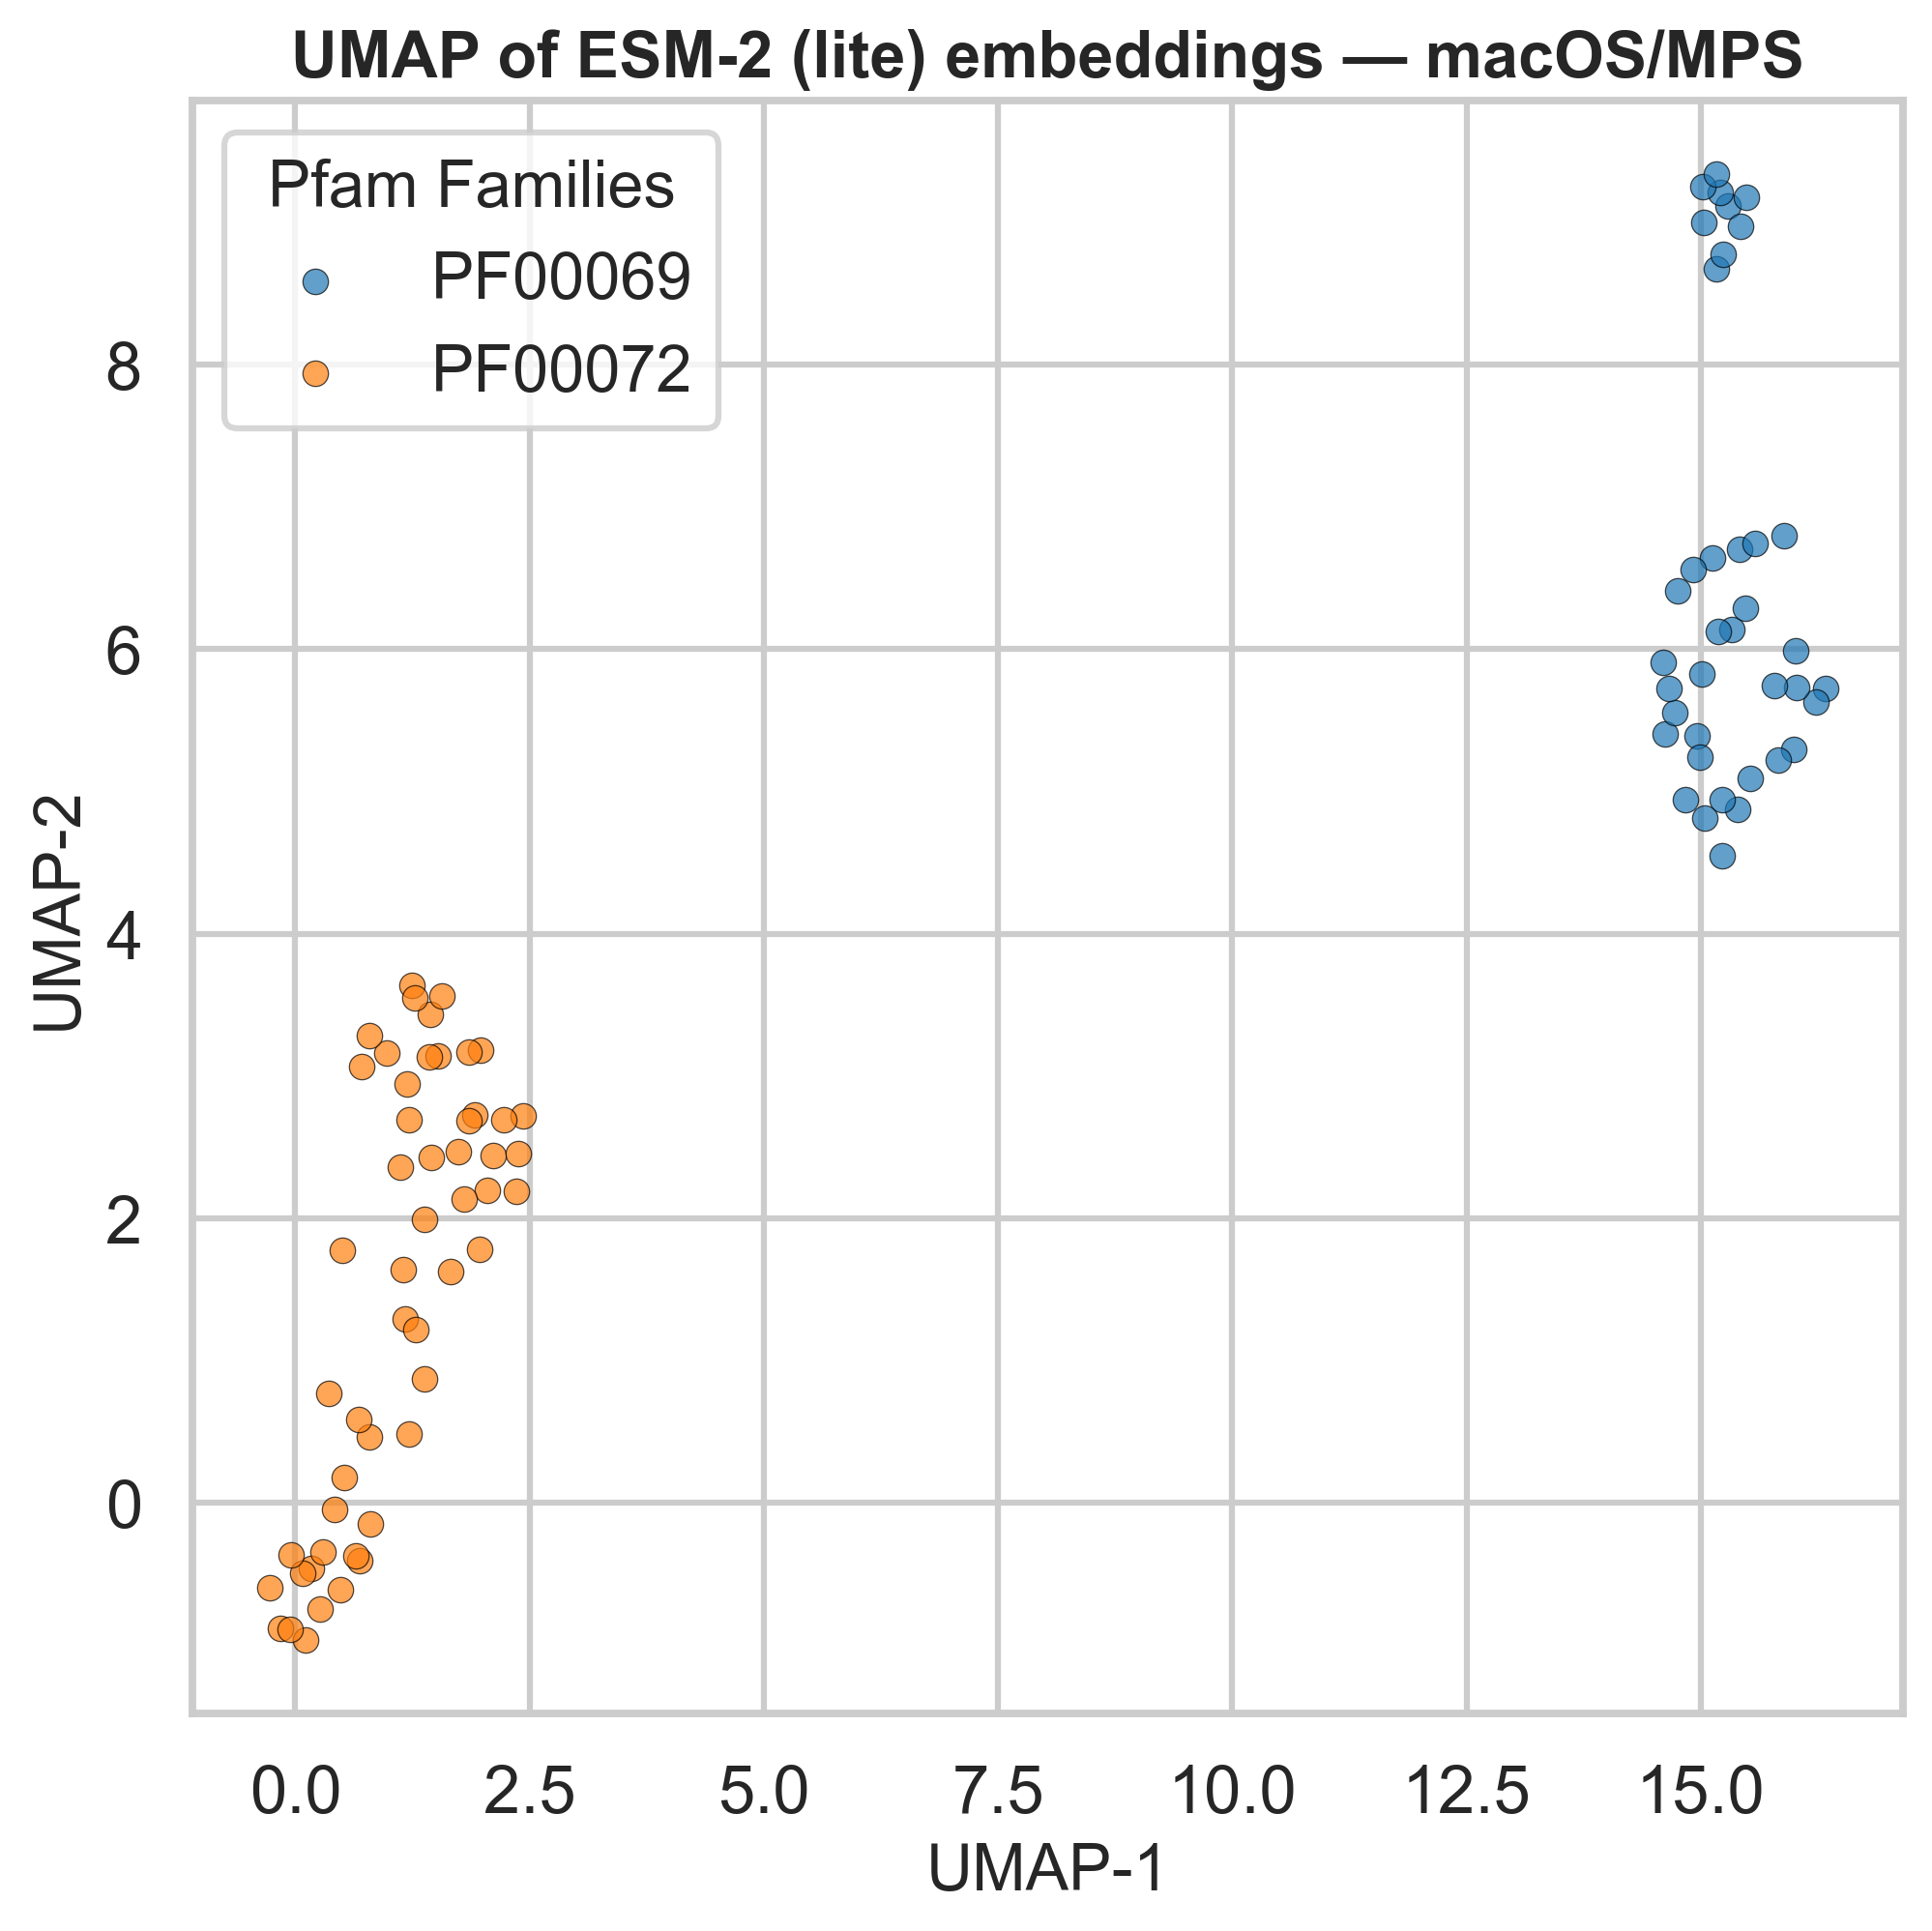

In [33]:
# --- Metrics: trustworthiness & 5-NN CV accuracy (cosine) ---
from sklearn.manifold import trustworthiness
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns

tw = trustworthiness(X_pca, X_umap, n_neighbors=10, metric="euclidean")
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs = cross_val_score(knn, X_umap, y_lite, cv=cv)
acc_mean, acc_sd = accs.mean(), accs.std()

print(f"Trustworthiness — UMAP (ESM-lite): {tw:.3f}")
print(f"5-NN CV accuracy — UMAP (ESM-lite): {acc_mean:.3f} ± {acc_sd:.3f}")

# --- Plot UMAP (styled) ---
sns.set_context("talk")
sns.set_style("whitegrid")

labels_arr = np.array(y_lite)
fams = sorted(set(labels_arr))
palette = sns.color_palette("tab10", n_colors=len(fams))

plt.figure(figsize=(7,7), dpi=300)
for fam, color in zip(fams, palette):
    mask = (labels_arr == fam)
    plt.scatter(
        X_umap[mask,0],
        X_umap[mask,1],
        label=fam,
        alpha=0.7,
        s=40,
        edgecolor="k",
        linewidth=0.3,
        color=color
    )

plt.title("UMAP of ESM-2 (lite) embeddings — macOS/MPS", fontsize=16, weight="bold")
plt.xlabel("UMAP-1", fontsize=16)
plt.ylabel("UMAP-2", fontsize=16)

plt.legend(
    title="Pfam Families",
    loc="best",
    fontsize=16,
    title_fontsize=16,
    frameon=True,
    fancybox=True,
    framealpha=0.8
)

plt.tight_layout()
plt.show()
